In [1]:
# Reading the input data
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


#### Reading input ply data

In [2]:
!pip install plyfile

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset
from plyfile import PlyData

def load_ply(path, with_faces=False, with_color=False):
    # print(path)
    ply_data = PlyData.read(path)
    points = ply_data['vertex']
    points = np.vstack([points['x'], points['y'], points['z']]).T
    ret_val = [points]

    if with_faces:
        faces = np.vstack(ply_data['face']['vertex_indices'])
        ret_val.append(faces)

    if with_color:
        r = np.vstack(ply_data['vertex']['red'])
        g = np.vstack(ply_data['vertex']['green'])
        b = np.vstack(ply_data['vertex']['blue'])
        color = np.hstack((r, g, b))
        ret_val.append(color)

    if len(ret_val) == 1:  # Unwrap the list
        ret_val = ret_val[0]

    return ret_val

def write_ply(points, output_path, faces=None, colors=None):
    with open(output_path, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write('element vertex {}\n'.format(len(points)))
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')

        if colors is not None:
            f.write('property uchar red\n')
            f.write('property uchar green\n')
            f.write('property uchar blue\n')

        if faces is not None:
            f.write('element face {}\n'.format(len(faces)))
            f.write('property list uchar int vertex_index\n')
            f.write('end_header\n')

            for point in points:
                f.write('{} {} {}\n'.format(point[0], point[1], point[2]))

            for face in faces:
                f.write('3 {} {} {}\n'.format(face[0], face[1], face[2]))
        else:
            f.write('end_header\n')

            for point in points:
                f.write('{} {} {}\n'.format(point[0], point[1], point[2]))


    # print("PLY file saved to:", output_path)



class PointCloudDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_paths = self._get_file_paths()

    def _get_file_paths(self):
        file_paths = []
        for root, dirs, files in os.walk(self.root_dir):
            for dir in dirs:
                subdir_path = os.path.join(root, dir)
                # print(subdir_path)
                for file in os.listdir(subdir_path):
                    if file.endswith(".ply"):
                        # print(os.path.join(subdir_path, file))
                        file_paths.append(os.path.join(subdir_path, file))
        return file_paths
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        ply_data = load_ply(self.file_paths[idx])
        points = torch.tensor(ply_data, dtype=torch.float32)
        return points


In [4]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


drive_root = '/content/drive/MyDrive/RLFinalProjectFiles'
org_root = os.path.join(drive_root, 'shape_net_core_uniform_samples_2048')

del_ratio = 50

# Define data loaders (using only train and test loaders)
batch_size = 1
train_data = PointCloudDataset(os.path.join(org_root + '_pointsremoved', 'train', str(del_ratio)))
test_data = PointCloudDataset(os.path.join(org_root + '_pointsremoved', 'test', str(del_ratio)))

print(train_data[0])

test_indices = list(range(len(test_data)))
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)

# Define datasets for validation and test
validation_data = Subset(test_data, val_indices)
test_data = Subset(test_data, test_indices)


tensor([[ 0.0080, -0.2378, -0.3604],
        [ 0.1333, -0.2293, -0.3604],
        [ 0.1775, -0.2266, -0.3604],
        ...,
        [ 0.1860, -0.2369,  0.3603],
        [ 0.1272, -0.2443,  0.3604],
        [ 0.1489, -0.2411,  0.3604]])


#### Encoder Decoder Definition

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Encoder(nn.Module):
#     def __init__(self, num_points):
#         super(Encoder, self).__init__()
#         self.num_points = num_points

#         self.encoder_conv1 = nn.Conv1d(3, 64, 1)
#         self.encoder_conv2 = nn.Conv1d(64, 128, 1)
#         self.encoder_fc1 = nn.Linear(128 * num_points, 1024)
#         self.encoder_fc2 = nn.Linear(1024, 256)

#         #  # Cast weight tensor and bias tensor to Double data type
#         # self.encoder_conv1.weight.data = self.encoder_conv1.weight.data.double()
#         # self.encoder_conv1.bias.data = self.encoder_conv1.bias.data.double()
#         # self.encoder_conv2.weight.data = self.encoder_conv2.weight.data.double()
#         # self.encoder_conv2.bias.data = self.encoder_conv2.bias.data.double()

#     def forward(self, x):
#         x = x.to(self.encoder_conv1.bias.dtype)
#         x = F.relu(self.encoder_conv1(x))
#         x = F.relu(self.encoder_conv2(x))
#         x = x.view(-1, 128 * self.num_points)
#         x = F.relu(self.encoder_fc1(x))
#         x = F.relu(self.encoder_fc2(x))
#         return x

# class Decoder(nn.Module):
#     def __init__(self, num_points):
#         super(Decoder, self).__init__()
#         self.num_points = num_points

#         self.decoder_fc1 = nn.Linear(256, 1024)
#         self.decoder_fc2 = nn.Linear(1024, 128 * num_points)
#         self.decoder_conv1 = nn.Conv1d(128, 64, 1)
#         self.decoder_conv2 = nn.Conv1d(64, 3, 1)

#     def forward(self, x):
#         x = F.relu(self.decoder_fc1(x))
#         x = F.relu(self.decoder_fc2(x))
#         x = x.view(-1, 128, self.num_points)
#         x = F.relu(self.decoder_conv1(x))
#         x = self.decoder_conv2(x)
#         return x

#### VAE class

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointCloudVariationalAutoencoder(nn.Module):
    def __init__(self, num_points, latent_dim):
        super(PointCloudVariationalAutoencoder, self).__init__()
        self.num_points = num_points
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv1 = nn.Conv1d(3, 64, 1)
        self.encoder_conv2 = nn.Conv1d(64, 128, 1)
        self.encoder_fc1 = nn.Linear(128 * num_points, 2048)
        self.encoder_fc2_mean = nn.Linear(2048, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(2048, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, 2048)
        self.decoder_fc2 = nn.Linear(2048, 128 * num_points)
        self.decoder_conv1 = nn.Conv1d(128, 64, 1)
        self.decoder_conv2 = nn.Conv1d(64, 3, 1)

        # Upsampling layer for encoder
        self.upsample = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        if x.size(-1) == 1024:  # Check if input size is 1024
            x = self.upsample(x)
        x = x.view(-1, 128 * self.num_points)
        x = F.relu(self.encoder_fc1(x))
        z_mean = self.encoder_fc2_mean(x)
        z_logvar = self.encoder_fc2_logvar(x)

        # Reparameterization trick
        epsilon = torch.randn_like(z_logvar)
        z = z_mean + torch.exp(0.5 * z_logvar) * epsilon

        # Decoder
        x = F.relu(self.decoder_fc1(z))
        x = F.relu(self.decoder_fc2(x))
        x = x.view(-1, 128, self.num_points)
        x = F.relu(self.decoder_conv1(x))
        x = self.decoder_conv2(x)

        return x, z

    def get_encoder(self):
        return Encoder(self.num_points, self.latent_dim)

    def get_decoder(self):
        return Decoder()

class Encoder(nn.Module):
    def __init__(self, num_points, latent_dim):
        super(Encoder, self).__init__()
        self.num_points = num_points
        self.latent_dim = latent_dim

        self.encoder_conv1 = nn.Conv1d(3, 64, 1)
        self.encoder_conv2 = nn.Conv1d(64, 128, 1)
        self.encoder_fc1 = nn.Linear(128 * num_points, 2048)
        self.encoder_fc2_mean = nn.Linear(2048, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(2048, latent_dim)

        # Upsampling layer for encoder
        self.upsample = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)

    def forward(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        if x.size(-1) == 1024:  # Check if input size is 1024
            x = self.upsample(x)
        x = x.view(-1, 128 * self.num_points)
        x = F.relu(self.encoder_fc1(x))
        z_mean = self.encoder_fc2_mean(x)
        z_logvar = self.encoder_fc2_logvar(x)
        return z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.feature_num = 256
        self.output_point_number = 2048

        self.linear1 = nn.Linear(self.feature_num, self.output_point_number*2)
        self.linear2 = nn.Linear(self.output_point_number*2, self.output_point_number*3)
        self.linear3 = nn.Linear(self.output_point_number*3, self.output_point_number*4)
        self.linear_out = nn.Linear(self.output_point_number*4, self.output_point_number*3)

        # Special initialization for linear_out to get a uniform distribution over the space
        self.linear_out.bias.data.uniform_(-1, 1)

    def forward(self, x):
        # Reshape from feature vector NxC to NxC
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear_out(x)

        return x.view(-1, 3, self.output_point_number)


#### Generator Discriminator Definition

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Generator(nn.Module):
    """Generator."""

    def __init__(self, z_dim=1, gfvs_dim=256, conv_dim=64):
        super(Generator, self).__init__()
        self.gfvs_dim = gfvs_dim

        # Calculate the initial image width based on the GFVs shape
        self.initial_image_width = int(gfvs_dim / (conv_dim * 4))

        # Adjust the input dimension to match the latent vector size
        self.fc = nn.Linear(z_dim, conv_dim * 8 * self.initial_image_width)

        # Define the convolutional layers
        self.conv1 = nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1)
        self.conv2 = nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, 2, 1)
        self.conv3 = nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1)
        self.conv4 = nn.ConvTranspose2d(conv_dim, 1, 4, 2, 1)

    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1, 64 * 8, self.initial_image_width, 1)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = torch.tanh(self.conv4(out))  # Apply tanh activation for image generation
        return out


class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, gfvs_dim=256, conv_dim=64):
        super(Discriminator, self).__init__()
        self.gfvs_dim = gfvs_dim

        # Calculate the final image size based on the GFVs shape
        self.final_image_size = int(np.sqrt(gfvs_dim/ conv_dim / 4))

        # Adjust the input dimension to match the GFVs size
        self.conv1 = nn.Conv2d(1, conv_dim, 4)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1)
        self.conv4 = nn.Conv2d(conv_dim * 4, 1, 1)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.conv4(out)
        return out.squeeze()  # Return a 1D output


#### Generator Discriminator with Self Attention

In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np

# class SelfAttention(nn.Module):
#     """Self Attention Layer."""

#     def __init__(self, in_dim):
#         super(SelfAttention, self).__init__()

#         self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
#         self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
#         self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
#         self.gamma = nn.Parameter(torch.zeros(1))

#     def forward(self, x):
#         batch, channels, height, width = x.size()

#         proj_query = self.query_conv(x).view(batch, -1, height*width).permute(0, 2, 1)
#         proj_key = self.key_conv(x).view(batch, -1, height*width)

#         energy = torch.bmm(proj_query, proj_key)
#         attention = F.softmax(energy, dim=-1)

#         proj_value = self.value_conv(x).view(batch, -1, height*width)

#         out = torch.bmm(proj_value, attention.permute(0, 2, 1))
#         out = out.view(batch, channels, height, width)

#         out = self.gamma * out + x
#         return out

# class Generator(nn.Module):
#     """Generator."""

#     def __init__(self, z_dim=1, gfvs_dim=256, conv_dim=64):
#         super(Generator, self).__init__()
#         self.gfvs_dim = gfvs_dim

#         # Calculate the initial image size based on the GFVs shape
#         self.initial_image_size = int(np.sqrt(gfvs_dim / conv_dim / 4))

#         # Adjust the input dimension to match the latent vector size
#         self.fc = nn.Linear(z_dim, conv_dim * 8 * self.initial_image_size * self.initial_image_size)

#         # Define the convolutional layers
#         self.conv1 = nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1)
#         self.sa1 = SelfAttention(conv_dim * 4)
#         self.conv2 = nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, 2, 1)
#         self.sa2 = SelfAttention(conv_dim * 2)
#         self.conv3 = nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1)
#         self.sa3 = SelfAttention(conv_dim)
#         self.conv4 = nn.ConvTranspose2d(conv_dim , 1, 4, 2, 1)  # Output should match GFVs size
#         self.fc_output = nn.Linear(conv_dim * self.initial_image_size * self.initial_image_size, gfvs_dim)

#     def forward(self, z):
#         out = self.fc(z)
#         out = out.view(-1, 64 * 8, self.initial_image_size, self.initial_image_size)
#         out = F.relu(self.conv1(out))
#         out = self.sa1(out)
#         out = F.relu(self.conv2(out))
#         out = self.sa2(out)
#         out = F.relu(self.conv3(out))
#         out = self.sa3(out)
#         out = torch.tanh(self.conv4(out))  # Apply tanh activation for image generation
#         # out = out.squeeze()  # Flatten the output
#         out = out.permute(0, 2, 3, 1)
#         out = out.view(-1, 64 * self.initial_image_size * self.initial_image_size) # Reshape to match GFVs dimension
#         return out





# class Discriminator(nn.Module):
#     """Discriminator."""

#     def __init__(self, gfvs_dim=256, conv_dim=64):
#         super(Discriminator, self).__init__()
#         self.gfvs_dim = gfvs_dim

#         # Calculate the final image size based on the GFVs shape
#         self.final_image_size = int(np.sqrt(gfvs_dim/ conv_dim / 4))

#         # Adjust the input dimension to match the GFVs size
#         self.conv1 = nn.Conv2d(1, conv_dim, 1)
#         self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, 3, 2, 1)
#         self.sa1 = SelfAttention(conv_dim * 2)
#         self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 4, 3, 2, 1)
#         self.sa2 = SelfAttention(conv_dim * 4)
#         self.conv4 = nn.Conv2d(conv_dim * 4, 1, 1)

#     def forward(self, x):
#         out = F.leaky_relu(self.conv1(x), 0.2)
#         out = F.leaky_relu(self.conv2(out), 0.2)
#         out = self.sa1(out)
#         out = F.leaky_relu(self.conv3(out), 0.2)
#         out = self.sa2(out)
#         out = self.conv4(out)
#         return out.squeeze()  # Return a 1D output


#### Reading saved AE, Generator and Discriminator models

In [7]:
model_dir = '/content/drive/MyDrive/RLFinalProjectFiles/models/'

encoder_state_dict = torch.load(model_dir + "vae_encoder3.pth")  # Load encoder weights
# encoder.eval()  # Set encoder to evaluation mode

decoder_state_dict = torch.load(model_dir + "vae_decoder3.pth")  # Load encoder weights
# decoder.eval()  # Set encoder to evaluation mode


#### Training RL agent using pretrained enc, dec, gen & dis

In [8]:
pc_dim = 2048
z_dim = 1

autoencoder = PointCloudVariationalAutoencoder(num_points=2048, latent_dim=256)
autoencoder.get_encoder().load_state_dict(encoder_state_dict)
autoencoder.get_decoder().load_state_dict(decoder_state_dict)

autoencoder.eval()

PointCloudVariationalAutoencoder(
  (encoder_conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (encoder_conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (encoder_fc1): Linear(in_features=262144, out_features=2048, bias=True)
  (encoder_fc2_mean): Linear(in_features=2048, out_features=256, bias=True)
  (encoder_fc2_logvar): Linear(in_features=2048, out_features=256, bias=True)
  (decoder_fc1): Linear(in_features=256, out_features=2048, bias=True)
  (decoder_fc2): Linear(in_features=2048, out_features=262144, bias=True)
  (decoder_conv1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (decoder_conv2): Conv1d(64, 3, kernel_size=(1,), stride=(1,))
  (upsample): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
)

In [9]:
gen_state_dict = torch.load(model_dir + "generator1.pth")  # Load generator weights
  # Set generator to evaluation mode

disc_state_dict = torch.load(model_dir + "discriminator1.pth")  # Load decoder weights


In [10]:
generator = Generator(z_dim=1, gfvs_dim=256, conv_dim=64)
discriminator = Discriminator(gfvs_dim=256)

generator.load_state_dict(gen_state_dict)
discriminator.load_state_dict(disc_state_dict)

# generator.eval()
# discriminator.eval()


<All keys matched successfully>

In [11]:
# enc_output = autoencoder.get_encoder()(torch.tensor(train_data))
fixed_z = torch.randn(1, z_dim)
gen_out = generator(fixed_z)
print(gen_out.shape)
gen_out = gen_out.view(1,256)
dec_output = autoencoder.get_decoder()(gen_out)
dec_output

torch.Size([1, 1, 16, 16])


tensor([[[-0.0174,  0.9913, -0.7400,  ...,  0.9463,  0.5616,  0.7763],
         [ 0.7197, -0.3247, -0.2558,  ...,  0.9189,  0.0347,  0.7379],
         [-0.9667, -0.2978,  0.4626,  ...,  0.6799,  0.2097,  0.2638]]],
       grad_fn=<ViewBackward0>)

#### Visualise decoder output

count of points:  1


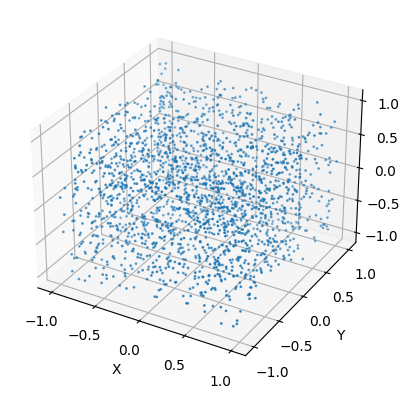

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_cloud(point_cloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example usage:
# Visualize a point cloud from the train dataset
example_point_cloud = dec_output.detach().numpy()
print("count of points: ",len(example_point_cloud))
visualize_point_cloud(example_point_cloud)
# visualize_point_cloud(train_data[0].detach().numpy())

#### Chamfer Loss function

In [13]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.2 MB/s eta 0:00:00


In [14]:
import torch
import numpy as np
import faiss

def robust_norm(var):
    '''
    :param var: Variable of BxCxHxW
    :return: p-norm of BxCxW
    '''
    result = ((var**2).sum(dim=2) + 1e-8).sqrt()
    # result = (var ** 2).sum(dim=2)

    # try to make the points less dense, caused by the backward loss
    # result = result.clamp(min=7e-3, max=None)
    return result

class ChamferLoss(nn.Module):
    def __init__(self, opt):
        super(ChamferLoss, self).__init__()
        self.opt = opt
        self.dimension = 3
        self.k = 1

        # we need only a StandardGpuResources per GPU
        # self.res = faiss.StandardGpuResources()
        # self.res.setTempMemoryFraction(0.1)

        # place holder
        self.forward_loss = torch.FloatTensor([0])
        self.backward_loss = torch.FloatTensor([0])

    def build_nn_index(self, database):
        '''
        :param database: numpy array of Nx3
        :return: Faiss index, in CPU
        '''
        index = faiss.IndexFlatL2(self.dimension)
        index.add(database)
        return index

    def search_nn(self, index, query, k):
        '''
        :param index: Faiss index
        :param query: numpy array of Nx3
        :return: D: Variable of Nxk, type FloatTensor, in CPU
                 I: Variable of Nxk, type LongTensor, in CPU
        '''
        D, I = index.search(query, k)

        D_var = torch.from_numpy(np.ascontiguousarray(D))
        I_var = torch.from_numpy(np.ascontiguousarray(I).astype(np.int64))

        return D_var, I_var

    def forward(self, predict_pc, gt_pc):
        '''
        :param predict_pc: Bx3xM Variable in CPU
        :param gt_pc: Bx3xN Variable in CPU
        :return:
        '''

        predict_pc_size = predict_pc.size()
        gt_pc_size = gt_pc.size()

        predict_pc_np = np.ascontiguousarray(torch.transpose(predict_pc.data.clone(), 1, 2).numpy())  # BxMx3
        gt_pc_np = np.ascontiguousarray(torch.transpose(gt_pc.data.clone(), 1, 2).numpy())  # BxNx3

        # selected_gt: Bxkx3xM
        selected_gt_by_predict = torch.FloatTensor(predict_pc_size[0], self.k, predict_pc_size[1], predict_pc_size[2])
        # selected_predict: Bxkx3xN
        selected_predict_by_gt = torch.FloatTensor(gt_pc_size[0], self.k, gt_pc_size[1], gt_pc_size[2])

        # process each batch independently.
        for i in range(predict_pc_np.shape[0]):
            index_predict = self.build_nn_index(predict_pc_np[i])
            index_gt = self.build_nn_index(gt_pc_np[i])

            # database is gt_pc, predict_pc -> gt_pc -----------------------------------------------------------
            _, I_var = self.search_nn(index_gt, predict_pc_np[i], self.k)

            # process nearest k neighbors
            for k in range(self.k):
                selected_gt_by_predict[i,k,...] = gt_pc[i].index_select(1, I_var[:,k])

            # database is predict_pc, gt_pc -> predict_pc -------------------------------------------------------
            _, I_var = self.search_nn(index_predict, gt_pc_np[i], self.k)

            # process nearest k neighbors
            for k in range(self.k):
                selected_predict_by_gt[i,k,...] = predict_pc[i].index_select(1, I_var[:,k])

        # compute loss ===================================================
        # selected_gt(Bxkx3xM) vs predict_pc(Bx3xM)
        forward_loss_element = robust_norm(selected_gt_by_predict-predict_pc.unsqueeze(1).expand_as(selected_gt_by_predict))
        self.forward_loss = forward_loss_element.mean()
        self.forward_loss_array = forward_loss_element.mean(dim=1).mean(dim=1)

        # selected_predict(Bxkx3xN) vs gt_pc(Bx3xN)
        backward_loss_element = robust_norm(selected_predict_by_gt - gt_pc.unsqueeze(1).expand_as(selected_predict_by_gt))  # BxkxN
        self.backward_loss = backward_loss_element.mean()
        self.backward_loss_array = backward_loss_element.mean(dim=1).mean(dim=1)

        # self.loss_array = self.forward_loss_array + self.backward_loss_array
        return self.forward_loss + self.backward_loss # + self.sparsity_loss

    def __call__(self, predict_pc, gt_pc):
        # start_time = time.time()
        loss = self.forward(predict_pc, gt_pc)
        # print(time.time()-start_time)
        return loss


#### MSE, NLL, Norm

In [15]:
class NLL(nn.Module):
    def __init__(self):
        super(NLL,self).__init__()
    def forward(self,x):
     #   neglog = - F.log_softmax(x,dim=0)
        # greater the value greater the chance of being real
        #probe = torch.mean(-F.log_softmax(x,dim=0))#F.softmax(x,dim=0)

      #  print(x.cpu().data.n/umpy())
       # print(-torch.log(x).cpu().data.numpy())
        return torch.mean(x)

class MSE(nn.Module):
    def __init__(self,reduction = 'elementwise_mean'):
        super(MSE,self).__init__()
        self.reduction = reduction
    def forward(self,x,y):
        mse = F.mse_loss(x,y,reduction =self.reduction)
        return mse


class Norm(nn.Module):
    def __init__(self,dims):
        super(Norm,self).__init__()
        self.dims =dims

    def forward(self,x):
        z2 = torch.norm(x,p=2)
        out = (z2-self.dims)
        out = out*out
        return out

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return '{:.3f} ({:.3f})'.format(self.val, self.avg)

#### DDPG Implementation



In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from collections import OrderedDict

device = torch.device("cpu")#("cuda" if torch.cuda.is_available() else "cpu")

# Implementation of Deep Deterministic Policy Gradients (DDPG)
# Paper: https://arxiv.org/abs/1509.02971

class ReplayBuffer(object):
	def __init__(self):
		self.storage = []

	# Expects tuples of (state, next_state, action, reward, done)
	def add(self, data):
		self.storage.append(data)

	def sample(self, batch_size=79):
			x, y, u, r, d = [], [], [], [], []

			for _ in range(batch_size):
						idx = np.random.randint(0, len(self.storage))
						X, Y, U, R, D = self.storage[idx]

						x.append(X)
						y.append(Y)
						u.append(U)
						r.append(R)
						d.append(D)

			# Convert lists to numpy arrays
			x = np.array(x)
			y = np.array(y)
			u = np.array(u)#.reshape(-1, 1)  # Reshape u, r, and d to match (batch_size, 1) shape
			r = np.array(r).reshape(-1, 1)
			d = np.array(d).reshape(-1, 1)

			return x, y, u, r, d


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 400)#400
		self.l2 = nn.Linear(400, 400)
		self.l2_additional = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, action_dim)

		self.max_action = max_action


	def forward(self, x):
		x = F.relu(self.l1(x))
		x = F.relu(self.l2(x))
		x = F.relu(self.l2_additional(x))
		x = self.max_action * torch.tanh(self.l3(x))
		return x


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3_additional = nn.Linear(300, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = F.relu(self.l1(x))
        # print("x size: ",x.size())
        # print("u size: "u.size())
        # u = u.view(u.size(0), -1)
        # x = x.squeeze(1)
        # u = u.squeeze(1)
        x = F.relu(self.l2(torch.cat([x, u], 2)))
        x = self.l3_additional(x)
        x = self.l3(x)
        return x



class DDPG(object):
	def __init__(self, state_dim, action_dim, max_action,device):
		self.device = device
		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target.load_state_dict(self.actor.state_dict())
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = Critic(state_dim, action_dim).to(device)
		self.critic_target.load_state_dict(self.critic.state_dict())
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), weight_decay=1e-2)


	def select_action(self, state):
		# state = torch.FloatTensor(state.reshape(batch_size, state_dim)).to(device)
		state = torch.FloatTensor(state).to(device)
		# print("state shape: ",state.shape)
		return self.actor(state).data.numpy().flatten()


	def train(self, replay_buffer, iterations, batch_size=79, discount=0.99, tau=0.001):

		for it in range(iterations):

				# Sample replay buffer
				x, y, u, r, d = replay_buffer.sample(batch_size)

				state = torch.FloatTensor(x).to(device)
				action = torch.FloatTensor(u).to(device)
				next_state = torch.FloatTensor(y).to(device)
				done = torch.FloatTensor(1 - d).to(device)
				reward = torch.FloatTensor(r).to(device)

				# Compute the target Q value
				target_Q = self.critic_target(next_state, self.actor_target(next_state))
				# print("target Q shape: ",target_Q.shape)
				target_Q = reward + (done * discount * target_Q).detach()

				# Get current Q estimate
				current_Q = self.critic(state, action)

				# Compute critic loss
				critic_loss = F.mse_loss(current_Q, target_Q)

				# Optimize the critic
				self.critic_optimizer.zero_grad()
				critic_loss.backward()
				self.critic_optimizer.step()

				# Compute actor loss
				actor_loss = -self.critic(state, self.actor(state)).mean()

				# Optimize the actor
				self.actor_optimizer.zero_grad()
				actor_loss.backward()
				self.actor_optimizer.step()

				# Update the frozen target models
				for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
					target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

				for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
					target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


	def save(self, filename, directory):
		torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
		torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))


	def load(self, filename, directory):
		self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
		self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

In [24]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import DataLoader, random_split
np.random.seed(5)
#torch.manual_seed(5)

def evaluate_policy(policy,valid_loader,env, eval_episodes=6,render = False):
    print("-----------------evaluating---------------")
    avg_reward = 0.
    env.reset(epoch_size=30,figures=8) # reset the visdom and set number of figures

    #for i,(input) in enumerate(valid_loader):
    for i in range (0,eval_episodes):
        try:
            input = next(dataloader_iterator)
        except:
            dataloader_iterator = iter(valid_loader)
            input = next(dataloader_iterator)

        obs =env.agent_input(input)# env(input, action_rand)
        done = False

        while not done:
          # Action By Agent and collect reward
            action = policy.select_action(np.array(obs))
            action= torch.tensor(action).unsqueeze(dim=0)
            new_state, _, reward, done = env( input, action,render=render,disp =True)
            avg_reward += reward

        if i+1 >= eval_episodes:
            break;

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print("Evaluation over %d episodes: %f" % (eval_episodes, avg_reward))
    print("---------------------------------------")

    return avg_reward

def test_policy(policy,valid_loader,env, eval_episodes=12,render = True):
    avg_reward = 0.
    env.reset(epoch_size=30,figures=12) # reset the visdom and set number of figures

    #for i,(input) in enumerate(valid_loader):
    for i in range (0,eval_episodes):
        try:
            input = next(dataloader_iterator)
        except:
            dataloader_iterator = iter(valid_loader)
            input = next(dataloader_iterator)

       # data_iter = iter(valid_loader)
       # input = data_iter.next()
        #action_rand = torch.randn(args.batch_size, args.z_dim)
        obs =env.agent_input(input)# env(input, action_rand)
        done = False

        while not done:
          # Action By Agent and collect reward
            action = policy.select_action(np.array(obs))
            action= torch.tensor(action).unsqueeze(dim=0)
            new_state, _, reward, done = env( input, action,render=render,disp =True)
            avg_reward += reward

        if i+1 >= eval_episodes:
            break;

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print("Evaluation over %d episodes: %f" % (eval_episodes, avg_reward))
    print("---------------------------------------")

    return avg_reward


def main():
    batch_size = 79

    sigma = 0.01
    clip = 0.05
    def jittered_data(input_data, sigma=0.01, clip=0.05):
        jittered_data = []
        for input_tensor in input_data:
            input_tensor = input_tensor.numpy()
            N, C = input_tensor.shape
            jitter = np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
            jittered = jitter + input_tensor
            jittered_data.append(torch.tensor(jittered))
        return jittered_data


    #Load data
    drive_root = '/content/drive/MyDrive/RLFinalProjectFiles'
    org_root = os.path.join(drive_root, 'shape_net_core_uniform_samples_2048')

    del_ratio = 50

    # Define data loaders (using only train and test loaders)
    batch_size = 79
    z_dim = 1
    train_data = PointCloudDataset(os.path.join(org_root + '_pointsremoved', 'train', str(del_ratio)))
    print("train data length ",len(train_data))
    test_data = PointCloudDataset(os.path.join(org_root + '_pointsremoved', 'test', str(del_ratio)))
    print("test data length ",len(test_data))
    dataset = train_data + test_data
    data_count = len(train_data) + len(test_data)

    train_length = 23*79  # Ensure each part is divisible by 79
    remaining_length = data_count - train_length
    validation_length = test_length = remaining_length // 2

    train_data, remaining_data = random_split(dataset, [train_length, len(dataset) - train_length])
    validation_data, test_data = random_split(remaining_data, [validation_length, test_length])


    train_data = jittered_data(train_data, sigma=sigma, clip=clip)
    validation_data = jittered_data(validation_data, sigma=sigma, clip=clip)
    test_data = jittered_data(test_data, sigma=sigma, clip=clip)


    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(validation_data,
                                               batch_size=1,
                                               shuffle=False,
                                               pin_memory=True)

    test_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=1,
                                               shuffle=False,
                                               pin_memory=True)


   #Pretrained model params

    # print('Encoder Model: {0}, Decoder Model : {1}'.format(model_encoder, model_decoder))
    # print('GAN Model Generator:{0} & Discriminator : {1} '.format(model_generator, model_discriminator))


    network_data_Enc = encoder_state_dict
    network_data_Dec = decoder_state_dict

    network_data_G = gen_state_dict

    network_data_D = disc_state_dict

    model_encoder = Encoder(num_points=2048, latent_dim=256)
    model_encoder.load_state_dict(network_data_Enc)

    model_decoder = Decoder()
    model_decoder.load_state_dict(network_data_Dec)

    model_G = Generator()
    model_G.load_state_dict(network_data_G)

    model_D = Discriminator()
    model_D.load_state_dict(network_data_D)



    # params = get_n_params(model_encoder)
    # print('| Number of Encoder parameters [' + str(params) + ']...')

    # params = get_n_params(model_decoder)
    # print('| Number of Decoder parameters [' + str(params) + ']...')



    chamfer = ChamferLoss({})
    nll = NLL()
    mse = MSE(reduction = 'elementwise_mean')
    norm = Norm(dims=z_dim)

    epoch = 0


    test_loss = trainRL(train_loader, valid_loader,test_loader, model_encoder, model_decoder, model_G,model_D, epoch, chamfer,nll, mse, norm)
    print('Average Loss :{}'.format(test_loss))


def trainRL(train_loader,valid_loader,test_loader,model_encoder,model_decoder, model_G,model_D,epoch, chamfer,nll, mse,norm):

    model_encoder.eval()
    model_decoder.eval()
    model_G.eval()
    model_D.eval()

    epoch_size = 30
    save_models = True
    policy_name = "ddpg"
    env_name = "RLGAN"


    file_name = "%s_%s" % (policy_name, env_name)

    if save_models and not os.path.exists("./pytorch_models"):
        os.makedirs("./pytorch_models")

    env = envs(model_G, model_D, model_encoder, model_decoder, epoch_size)

    state_dim = 256
    action_dim = 1
    max_action = 10
    # gpu_id = 1
    device = torch.device("cpu")#torch.device(
        # "cuda:%d" % (gpu_id) if torch.cuda.is_available() else "cpu")

    # Initialize policy

    policy = DDPG(state_dim, action_dim, max_action, device)

    replay_buffer = ReplayBuffer()

    evaluations = [evaluate_policy(policy,valid_loader,env)]



    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    max_episodes_steps = 5
    episode_reward = 0
    episode_timesteps = 0
    done = True
    env.reset(epoch_size=30)

    max_timesteps = 1000


    while total_timesteps < max_timesteps:


        if done:

            try:
                input = next(dataloader_iterator)
            except:
                dataloader_iterator = iter(train_loader)
                input = next(dataloader_iterator)

            # num_elements = sum(1 for _ in dataloader_iterator)
            print("input shape, ")
            if total_timesteps != 0:
                batch_size = input.shape[0]
                discount = 0.99
                tau = 0.005
                print("------------training--------------")
                # print("Total T: %d Episode Num: %d Episode T: %d Reward: %f") % (total_timesteps, episode_num, episode_timesteps, episode_reward)
                policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau)

            eval_freq = 300
            # Evaluate episode
            if timesteps_since_eval >= eval_freq:
                timesteps_since_eval %= eval_freq

                evaluations.append(evaluate_policy(policy,valid_loader,env,render = False))

                if save_models: policy.save(file_name, directory="./pytorch_models")

                env.reset(epoch_size=30)
                print("------------testing policy-----------")
                test_policy(policy, test_loader, env, render=True)

                env.reset(epoch_size=30)


            # Reset environment
           # obs = env.reset()
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1

        # Select action randomly or according to policy
        obs = env.agent_input(input)
        start_timesteps = 100
        expl_noise = 0.1
        max_action = 1
        batch_size = input.shape[0]
        z_dim = 1

        if total_timesteps < start_timesteps:
          #  action_t = torch.rand(args.batch_size, args.z_dim) # TODO checked rand instead of randn
            action_t = torch.FloatTensor(batch_size, z_dim).uniform_(-max_action, max_action)
            action = action_t.detach().numpy()#.squeeze(0)
        else:

            action = policy.select_action(np.array(obs))
            if expl_noise != 0:
                action = (action + np.random.normal(0, expl_noise, size=z_dim)).clip(-max_action * np.ones(z_dim,), max_action * np.ones(z_dim,))

        #      Convert each element of action to a list containing a single element
            action = np.array([[np.float32(a)] for a in action])
            action_t = torch.tensor(action).unsqueeze(dim=0)
        # Perform action

        new_obs, _, reward, done = env(input, action_t,disp = True)

       # new_obs, reward, done, _ = env.step(action)
        done_bool = 0 if episode_timesteps + 1 == max_episodes_steps else float(done)
        episode_reward += reward

        # Store data in replay buffer
        replay_buffer.add((obs, new_obs, action, reward, done_bool))

        obs = new_obs

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1
        print("epsiode_timesteps: ",episode_timesteps)
        print("total_timesteps: ",total_timesteps)

class envs(nn.Module):
    def __init__(self,model_G,model_D,model_encoder,model_decoder,epoch_size):
        super(envs,self).__init__()

        self.nll = NLL()
        self.mse = MSE(reduction='elementwise_mean')
        z_dim = 1
        self.norm = Norm(dims=z_dim)
        self.chamfer = ChamferLoss({})
        self.epoch = 0
        self.epoch_size =epoch_size

        self.model_G = model_G
        self.model_D = model_D
        self.model_encoder = model_encoder
        self.model_decoder = model_decoder
        self.j = 1
        self.figures = 3
        self.attempts = 5
        self.end = time.time()
        self.batch_time = AverageMeter()
        self.state_dim = 128
        self.attempt_id =0
        self.state_prev = np.zeros([4,])
        self.iter = 0
    def reset(self,epoch_size, figures =3):
        self.j = 1;
        self.i = 0;
        self.figures = figures;
        self.epoch_size= epoch_size
        # print("epoch_size: ",self.epoch_size)
        # self.batch_size = batch_size
    def agent_input(self,input):
        with torch.no_grad():
            input = input
            # input_var = Variable(input, requires_grad=True)
            input = input.transpose(1,2)
            print("input shape: ",input.shape)
            if input.size(-1) == 1024:
                # Define the desired output size for upsampling
                desired_size = 2048

                # Calculate the scale factor for upsampling
                scale_factor = desired_size / input.size(-1)

                # Upsample the input tensor using bilinear interpolation
                input_upsampled = F.interpolate(input.float(), scale_factor=scale_factor, mode='nearest-exact')

                # Pass the upsampled input to the encoder
                encoder_out_mean, encoder_out_logvar = self.model_encoder(input_upsampled)
            else:
                # If input size does not match, directly pass the input to the encoder
                encoder_out_mean, encoder_out_logvar = self.model_encoder(input.float())

            # Reparameterization trick
            epsilon = torch.randn_like(encoder_out_logvar)
            encoder_out = encoder_out_mean + torch.exp(0.5 * encoder_out_logvar) * epsilon
            out = encoder_out.detach().numpy().squeeze()
        return out
    def forward(self,input,action,render=False, disp=False):
        state_dim = 256
        with torch.no_grad():
            # Encoder Input
            input = input
            # input_var = Variable(input, requires_grad=True)

            # Encoder  output
            input = input.transpose(1,2)
            if input.size(-1) == 1024:
              input = F.interpolate(input.float(), scale_factor=2, mode='nearest-exact')

            # for VAE
            encoder_out_mean, encoder_out_logvar = self.model_encoder(input.float())
            # Reparameterization trick
            epsilon = torch.randn_like(encoder_out_logvar)
            encoder_out = encoder_out_mean + torch.exp(0.5 * encoder_out_logvar) * epsilon
            # print("encoder_out shape: ",encoder_out.shape)

            # D Decoder Output
            pc_1 = self.model_decoder(encoder_out)
            # Generator Input
            # z = Variable(action, requires_grad=True)#.cuda()
            z = action
            z = z.view(-1,1)

            # Generator Output
            # print(  "z shape: ",z.shape)
            out_GD = self.model_G(z)
            # print("----out_GD shape ",out_GD.shape)
            out_G = torch.squeeze(out_GD, dim=1)
            num_samples = encoder_out.shape[0]
            out_G = out_G[:num_samples]
            out_G = out_G.contiguous().view(-1, state_dim)

            # Discriminator Output
            out_D = self.model_D(out_GD) # TODO Alert major mistake

            # H Decoder Output
            pc_1_G = self.model_decoder(out_G)


            # Preprocesing of Input PC and Predicted PC for Visdom
            # print("input-------- ",input.shape)
            trans_input = torch.squeeze(input, dim=1)
            trans_input = torch.transpose(trans_input, 1, 2)
            trans_input_temp = trans_input[0, :, :]
            pc_1_temp = pc_1[0, :, :] # D Decoder PC
            pc_1_G_temp = pc_1_G[0, :, :] # H Decoder PC


        # Discriminator Loss
        loss_D = self.nll(out_D)

        # print("outG shape: ",out_G.shape)
        # print("encoder out shape: ",encoder_out.shape)
        # Loss Between Noisy GFV and Clean GFV
        loss_GFV = self.mse(out_G, encoder_out)

        # Norm Loss
        loss_norm = self.norm(z)

        # Chamfer loss
        # print("pc1g shape ",pc_1_G.shape)
        # print("pc1 shape ",pc_1.shape)
        loss_chamfer = self.chamfer(pc_1_G, pc_1)

        # States Formulation
        state_curr = np.array([loss_D.data.numpy(), loss_GFV.data.numpy()
                                  , loss_chamfer.data.numpy(), loss_norm.data.numpy()])
      #  state_prev = self.state_prev

        reward_D = state_curr[0]#state_curr[0] - self.state_prev[0]
        reward_GFV =-state_curr[1]# -state_curr[1] + self.state_prev[1]
        reward_chamfer = -state_curr[2]#-state_curr[2] + self.state_prev[2]
        reward_norm =-state_curr[3] # - state_curr[3] + self.state_prev[3]
        # Reward Formulation
        reward = ( reward_D *0.01 + reward_GFV * 10.0 + reward_chamfer *100.0 + reward_norm*1/10)

        # measured elapsed time
        self.batch_time.update(time.time() - self.end)
        self.end = time.time()

        if disp:
            print('[{4}][{0}/{1}]\t Reward: {2}\t States: {3}'.format(self.i, self.epoch_size,reward,state_curr,self.iter))
            self.i += 1
            if(self.i>=self.epoch_size):
                self.i=0
                self.iter +=1

        done = True
        state = out_G.detach().data.numpy().squeeze()
        # print("State: ",state)
        # print("Reward: ",reward)
        # print("Done: ",done)
        return state, _, reward, done



if __name__ == '__main__':

    main()









train data length  1824
test data length  783
-----------------evaluating---------------
input shape:  torch.Size([1, 3, 1024])
[0][0/30]	 Reward: -21.445465255379677	 States: [-0.18434232  1.0996633   0.1036447   0.8251937 ]
input shape:  torch.Size([1, 3, 1024])


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Streaming output truncated to the last 5000 lines.
total_timesteps:  189
input shape, 
------------training--------------
input shape:  torch.Size([79, 3, 1024])
[6][9/30]	 Reward: -26.854869256317613	 States: [-0.18435219  1.0562485   0.1006818  62.223606  ]
epsiode_timesteps:  1
total_timesteps:  190
input shape, 
------------training--------------
input shape:  torch.Size([79, 3, 1024])
[6][10/30]	 Reward: -26.913750002682207	 States: [-0.18435219  1.0558008   0.10131538 62.223606  ]
epsiode_timesteps:  1
total_timesteps:  191
input shape, 
------------training--------------
input shape:  torch.Size([79, 3, 1024])
[6][11/30]	 Reward: -26.854184398949144	 States: [-0.18435219  1.0507718   0.10122262 62.223606  ]
epsiode_timesteps:  1
total_timesteps:  192
input shape, 
------------training--------------
input shape:  torch.Size([79, 3, 1024])
[6][12/30]	 Reward: -26.965932379066942	 States: [-0.18435219  1.0614865   0.10126863 62.223606  ]
epsiode_timesteps:  1
total_timesteps:  193
